# Debugging your optimizations

## Main message
Optimization of complicated multidisciplinary systems is not easy. By following this systematic debugging procedure you can maximize your chances of success.

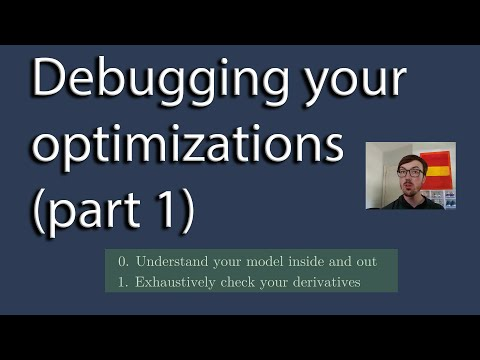

In [15]:
from IPython.display import YouTubeVideo; YouTubeVideo('wTPggiKYuPA', width=1024, height=576)

Video transcript available on YouTube and [here.](../VideoTranscripts/debugging_opts_1.md)

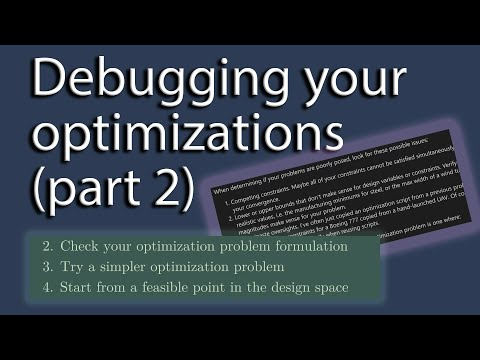

In [1]:
from IPython.display import YouTubeVideo; YouTubeVideo('7tTDrMIuQeM', width=1024, height=576)

Video transcript available on YouTube and [here.](../VideoTranscripts/debugging_opts_2.md)

## Context
Setting up, formulating, running, and interpreting complicated multidisciplinary optimizations is no small feat. It takes years of work to understand all the nuances and hone the craft of designing complex engineering systems. You'll spend countless hours looking at numbers and wishing they were different numbers, wondering why they weren't those other numbers. But don't fear! You're not alone. We can and will get through this together.

These tips are mostly focused on gradient-based design optimization, though some deal with optimization in general. This list does not focus on gradient-free optimizer specific considerations.

## Checklist

This checklist serves to reduce the amount of time you spend debugging your optimizations. By diagnosing and mitigating your problems with these tips, I hope you can achieve numerical design peace sooner than later.

Sometimes the hard part is just *diagnosing* why your optimization is failing. Other times the hard work is in actually *solving* the issues. I hope that this checklist helps with both, though I definitely don't have the answers for everything. Most of this checklist first tells you how to diagnose what's going on, then I offer a few solutions.

This checklist is focused on getting you optimizations to converge (or "run"), and is not necessarily focused on performance or speed improvements to your optimization. I suggest you follow these debugging steps roughly in order as they build upon each other. For instance, if your derivatives are incorrect it doesn't help to scale your problem.

### 0\. Understand your model inside and out

It's too easy to make a model and not understand it and give it to the optimizer. But optimizers (in)famously push models to their limits, especially multidisciplinary ones. There are concrete ways to better understand your model:

1. Parameter sweeps (or [design of experiments](https://openmdao.org/twodocs/versions/latest/features/building_blocks/drivers/doe_driver.html)), especially on DVs. See how multimodal or bumpy the design space is.
2. Use the [N2 diagram](https://openmdao.org/twodocs/versions/latest/features/model_visualization/n2_basics/n2_basics.html) to check for out-of-order executions or missed connections.
3. Use [list_outputs](https://openmdao.org/twodocs/versions/latest/features/debugging/listing_variables.html) at your initial point and make sure all the numbers make sense. Are the magnitudes wildly off? Do they make intuitive sense?
4. If you're getting solver convergence issues, check out [How to debug solvers](../ModelConstruction/how_to_debug_solvers.ipynb) for more details.
5. Try adding [lower and upper bounds to outputs within the model](https://openmdao.org/twodocs/versions/latest/features/building_blocks/solvers/bounds_enforce.html) to help guide the solvers. This is different than adding bounds on your design variables. Instead of guiding the optimizer, these bounds can help guide internal analysis solvers.
6. Use the `err_on_non_converge` option in solvers. This option is valuable at the top most solver of the model, but probably shouldn't be used on lower level solvers.

I'll show you some of these tips in action with some examples.

First up, here's an example of a parameter sweep on one of the sample problems; a paraboloid. By visualizing the design space you can get a feel for how the optimization should perform. Obviously this is easier for simple problems but you can do this for portions of more complex problems as well.

/home/john/anaconda3/envs/course/lib/python3.8/site-packages/openmdao/recorders/sqlite_recorder.py:227: UserWarning:The existing case recorder file, cases.sql, is being overwritten.
/home/john/anaconda3/envs/course/lib/python3.8/site-packages/openmdao/visualization/opt_report/opt_report.py:123: DriverWarning:The optimizer report is not applicable for the DOEDriver Driver which does not support optimization


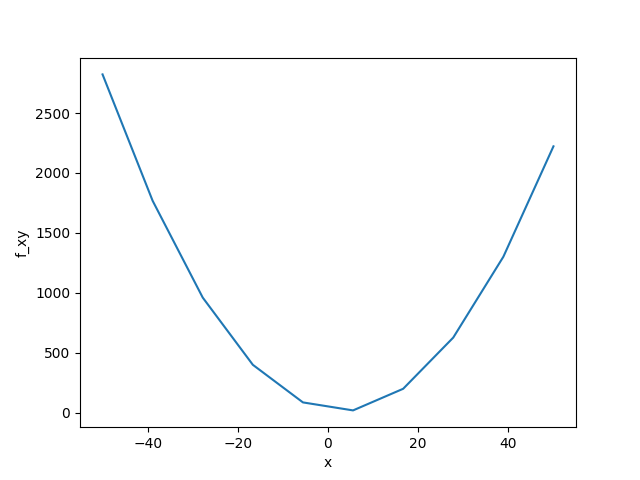

In [16]:
from openmdao.test_suite.components.paraboloid import Paraboloid
import openmdao.api as om
import matplotlib.pyplot as plt
import numpy as np


# build the model
prob = om.Problem()
prob.model.add_subsystem('parab', Paraboloid(), promotes=['*'])

prob.model.set_input_defaults('x', 3.0)

# setup the optimization
prob.driver = om.DOEDriver(om.FullFactorialGenerator(levels=10))
prob.driver.add_recorder(om.SqliteRecorder("cases.sql"))

prob.model.add_design_var('x', lower=-50, upper=50)
prob.model.add_objective('f_xy')

prob.setup()
prob.run_driver();

cr = om.CaseReader("cases.sql");
cases = cr.list_cases('driver', out_stream=None)

x = []
f_xy = []
for case in cases:
    outputs = cr.get_case(case).outputs;
    x.append(outputs['x'])
    f_xy.append(outputs['f_xy'])

plt.plot(x, f_xy)
plt.xlabel('x')
plt.ylabel('f_xy');

Next we use `err_on_non_converge`, `debug_print`, and `list_outputs` to better understand how the model is converging. All of these can help reveal potential issues in your model, especially when optimizers push them to the edge.

In [17]:
from openmdao.test_suite.scripts.circuit_analysis import Circuit

p = om.Problem()
model = p.model

model.add_subsystem('circuit', Circuit())

p.setup()

nl = model.circuit.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)

nl.options['iprint'] = 2
nl.options['debug_print'] = True
nl.options['err_on_non_converge'] = True

# set some poor initial guesses so that we don't converge
p.set_val('circuit.I_in', 0.1, units='A')
p.set_val('circuit.Vg', 0.0, units='V')
p.set_val('circuit.n1.V', 10.)
p.set_val('circuit.n2.V', 1e-3)

try:
    p.run_model()
except om.AnalysisError:
    print("Model failed as expected")
p.model.list_outputs(units=True)


circuit
NL: Newton 0 ; 2.53337743 1
NL: Newton 1 ; 6.97216645e+152 2.75212306e+152
NL: Newton 2 ; 2.56496626e+152 1.01246906e+152
NL: Newton 3 ; 9.43616587e+151 3.72473748e+151
NL: Newton 4 ; 3.47143851e+151 1.37028082e+151
NL: Newton 5 ; 1.27709554e+151 5.04107884e+150
NL: Newton 6 ; 4.69826271e+150 1.8545451e+150
NL: Newton 7 ; 1.72842766e+150 6.822622e+149
NL: Newton 8 ; 6.35865288e+149 2.50995087e+149
NL: Newton 9 ; 2.33926287e+149 9.23377165e+148
NL: Newton 10 ; 8.60583345e+148 3.39698039e+148
NL: NewtonSolver 'NL: Newton' on system 'circuit' failed to converge in 10 iterations.

# Inputs and outputs at start of iteration 'rank0:root._solve_nonlinear|0|NLRunOnce|0|circuit._solve_nonlinear|0':

# nonlinear inputs
{'circuit.D1.V_in': array([1.]),
 'circuit.D1.V_out': array([0.]),
 'circuit.R1.V_in': array([1.]),
 'circuit.R1.V_out': array([0.]),
 'circuit.R2.V_in': array([1.]),
 'circuit.R2.V_out': array([1.]),
 'circuit.n1.I_in:0': array([0.1]),
 'circuit.n1.I_out:0': array([1.]),

[('circuit.R1.I', {'val': array([0.09997694]), 'units': 'A'}),
 ('circuit.R2.I', {'val': array([2.30559559e-05]), 'units': 'A'}),
 ('circuit.D1.I', {'val': array([0.]), 'units': 'A'}),
 ('circuit.n1.V', {'val': array([9.9976944]), 'units': 'V'}),
 ('circuit.n2.V', {'val': array([9.76713485]), 'units': 'V'})]

### 1\.  Exhaustively check your derivatives at multiple design points

When I say exhaustively, I mean it. Checking your derivatives at the initial design point is absolutely necessary, but it's not sufficient to being confident in your derivative calculations. Your optimizer will move around the design space in all sorts of ways, moving variables and the corresponding derivatives to different values.

Luckily, OpenMDAO has some tools to help you. I'll also go through a mini-checklist here to recap how to check your derivatives. This topic is covered in more detail in other lessons. There are also [numerous OpenMDAO doc pages](https://openmdao.org/twodocs/versions/latest/features/core_features/working_with_derivatives/main.html) related to this topic.

1. This is the first one because it's the most straightforward and doesn't require you to run your model. Are any systems missing a linear solver? If there's a nonlinear solver on a model, you generally need a linear solver as well. This linear solver is what computes the derivatives for multidisciplinary systems. It's *way* too easy to forget to add a linear solver, so I highly suggest checking through your model first! [Understanding N2 diagrams](../ModelConstruction/using_n2) diagrams can help you see places where a solver is missing too.
2. Use [check_partials](http://openmdao.org/twodocs/versions/latest/features/core_features/working_with_derivatives/basic_check_partials.html)! This helps you verify your derivatives for individual portions of your model. If your partials are not correct, then your total derivatives (the ones fed to the optimizer) will be wrong. You can check your partials using finite differencing or complex-step.
3. Use [check_totals](https://openmdao.org/twodocs/versions/latest/features/core_features/working_with_derivatives/check_total_derivatives.html)! Just like the partials you can use finite differencing or complex-step. These total derivatives are exactly what is passed to the optimizer, so if they're wrong you can expect pretty poor optimizer performance.
4. I mentioned this in the intro to this subsection, but make sure to check your derivatives at multiple points in the design space. There may be certain areas where the derivatives are wrong whereas they appear correct in all other areas. Some examples of how this could crop up are from if-then conditions, singularities in the physics models, or at weird combinations of your design variables. Maybe it doesn't make intuitive sense to twist your aircraft wing into a crazy shape, but your optimizer might do that. You need to make sure the derivatives are correct *even there* so the optimizer knows how to escape this poor design point.

### 2\. Check your optimization problem formulation

Again and again! It's very easy to write a poorly posed optimization problem. What I mean by poorly posed is that the problem is challenging for the optimizer to solve, either due to mathematic or computational considerations. We can usually reformulate poorly posed problems into well-posed problems.

When determining if your problems are poorly posed, look for these possible issues:
1. Competing constraints. Maybe all of your constraints cannot be satisfied simultaneously. Try turning off constraints one at a time to see if it helps your convergence.
2. Lower or upper bounds that don't make sense for design variables or constraints. Verify that all of your design variable bounds are based on realistic values, i.e. the manufacturing minimums for steel, or the max width of a wind turbine tower due to traincars. Make sure the units and magnitudes make sense for your problem.
3. Copy/paste oversights. I've often just copied an optimization script from a previous problem without looking at everything in detail. In one case I was trying to use constraints for a Boeing 777 copied from a hand-launched UAV. Of course those constraint values would be incorrect! Take a look for real simple errors, especially when reusing scripts.

Handwaving a lot of mathematics away, a well-posed optimization problem is one where:
- there are no design variables that control the same performance metrics in the same way (think wing twist and airfoil angle of attack for a wing design problem)
- the combination of constraints and design variable bounds mean that there are feasible points in the design space
- the objective function is sensitive to most of the design variables at roughly the same order of magnitude
- the optimizer makes steady progress throughout the optimization and doesn't get "stuck" before failing to converge
- you as the engineer or researcher can interpret the results using physical intuition

Here's a simple example of a poorly posed optimization problem. We're trying to optimize a constrained paraboloid function, but the constraint cannot be satisfied with the prescribed bounds on the design variables. We'd have to either change the bounds or the constraint or hit the whiteboard and develop a different optimization problem.

The optimizer fails with a "positive directional derivative for linesearch," which just means that it was trying its best up until it could not improve the function. This is usually a good sign to check your problem formulation or derivatives.

In [18]:
from openmdao.test_suite.components.paraboloid import Paraboloid

# build the model
prob = om.Problem()
prob.model.add_subsystem('parab', Paraboloid(), promotes_inputs=['x', 'y'])

# define the component whose output will be constrained
prob.model.add_subsystem('const', om.ExecComp('g = x + y'), promotes_inputs=['x', 'y'])

# Design variables 'x' and 'y' span components, so we need to provide a common initial
# value for them.
prob.model.set_input_defaults('x', 3.0)
prob.model.set_input_defaults('y', -4.0)

# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'

prob.model.add_design_var('x', lower=10, upper=50)
prob.model.add_design_var('y', lower=0, upper=50)
prob.model.add_objective('parab.f_xy')

# to add the constraint to the model
prob.model.add_constraint('const.g', equals=5)

prob.setup()
prob.run_driver();

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 62.0
            Iterations: 10
            Function evaluations: 46
            Gradient evaluations: 6
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


### 3\. Try a simpler optimization problem

Use fewer design variables, fewer constraints, or a cheaper analysis. This is both solution and diagnosis.

It usually pays to try a simpler problem first, not just because it's easier to converge the optimization, but also so you can better understand the results. Imagine if you're optimizing a wind turbine blade and want to eventually include twist, chord, airfoil shape, and structural parameters. If you just give all of those to the optimizer without first running a twist-only optimization, you probably won't see good convergence in your optimization. At the very least, you won't know which parts of the performance gains come from different changes in the design.

Another way to more quickly debug your system is to use a cheaper analysis. I don't necessarily mean changing fidelity levels or your model, but if you're simulating 1000 seconds of system operation try 10 seconds first. This will allow you to run optimizations more quickly and understand results sooner.

### 4\. Start from a feasible point in the design space

Optimizers might not be able to find a feasible point. Do your initial conditions make sense? Use your engineering knowledge to pick a reasonable starting point. Again more solution than diagnosis.

If you're asking the optimizer to start from a point in the design space where the constraints are not satisfied, it will focus on simply trying to satisfy those constraints instead of improving the objective function. This *might* be okay and work out fine, but it also might make the optimizer get trapped in a point in the design space that is non-optimal. Plus you can just save time by starting it out at a feasible point.

The next tip helps you see your constraint values to make sure you're starting out at a feasible point.

### 5\. Use [driver debug printing](https://openmdao.org/twodocs/versions/latest/features/debugging/debugging_drivers.html)

This helps you watch your DVs, constraints, and derivatives; it's a great diagnostic tool. This might be a huge amount of information for challenging and complicated problems, but I suggest always using driver debug printing and piping it to a file so you can parse through it later. If you're running many different optimization cases it helps you quickly see the trends as they're running so you can stop the process if it's stuck or if your model is failing.

Driver debug printing is pretty full-featured and allows you to choose if you see design variables, constraints, objectives, and derivatives from each iteration of your optimization. The derivatives printing is especially helpful if you're optimizer moves to a point in the design space that you haven't investigated before. This will allow you to look at the derivatives there and see if they match your intuition.

Here's a simple driver debug printing example from the docs.

In [19]:
prob = om.Problem()
model = prob.model

model.add_subsystem('comp', Paraboloid(), promotes=['*'])
model.add_subsystem('con', om.ExecComp('c = - x + y'), promotes=['*'])

model.set_input_defaults('x', 50.0)
model.set_input_defaults('y', 50.0)

prob.set_solver_print(level=0)

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['tol'] = 1e-9
prob.driver.options['disp'] = False

prob.driver.options['debug_print'] = ['desvars','ln_cons','nl_cons','objs']

model.add_design_var('x', lower=-50.0, upper=50.0)
model.add_design_var('y', lower=-50.0, upper=50.0)
model.add_objective('f_xy')
model.add_constraint('c', upper=-15.0)

prob.setup()

prob.run_driver()

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|0
--------------------------------------------------------------
Design Vars
{'x': array([50.]), 'y': array([50.])}

Nonlinear constraints
{'con.c': array([0.])}

Linear constraints
None

Objectives
{'comp.f_xy': array([7622.])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|1
--------------------------------------------------------------
Design Vars
{'x': array([50.]), 'y': array([50.])}

Nonlinear constraints
{'con.c': array([0.])}

Linear constraints
None

Objectives
{'comp.f_xy': array([7622.])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|2
--------------------------------------------------------------
Design Vars
{'x': array([-35.]), 'y': array([-50.])}

Nonlinear constraints
{'con.c': array([-15.])}

Linear constraints
None

Objectives
{'comp.f_xy': array([5307.])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|3
------------------------------------------------------------

False

### 6\. Plot variable history vs optimizer iterations

Maybe something will jump out at you! It's a fantastic and visual way to see how your optimizer is handling the problem.

There is an experimental [built-in tool in OpenMDAO](https://openmdao.org/twodocs/versions/latest/features/model_visualization/case_viewer_driver_cases.html) that helps you do this. A screenshot of this tool is shown below. The [CaseReader](https://openmdao.org/twodocs/versions/latest/features/recording/case_reader.html) in OpenMDAO also helps you postprocess and debug your optimizations by reading the variable histories during the optimization.

If you are using [PyOptSparse](https://github.com/mdolab/pyoptsparse/) within OpenMDAO, it also has a built-in tool call OptView that can help you interactively visualize your optimization history.

![View optimization variables and iterations](case_viewer_y_vs_case.png)



In [20]:
class Fence(om.ExplicitComponent):

    def initialize(self):
        self.options.declare('n', types=int, default=50, desc='number of fenceposts')

    def setup(self):
        n = self.options['n']
        self.add_input('L', val=10.0, units='m')
        self.add_input('y', val=np.zeros(n), units='m')

        self.add_output('perimeter', val=0.0, units='m')
        self.add_output('area', val=0.0, units='m**2')
        self.add_output('x', val=np.linspace(0, 100, n), units='m')

        self.declare_partials(of='*', wrt='*', method='cs')

    def compute(self, inputs, outputs):
        n = self.options['n']
        L = inputs['L']
        y = inputs['y']

        x = np.linspace(0, L, n)

        dx = x[1:] - x[:-1]
        dy = y[1:] - y[:-1]

        mean_y = 0.5 * (y[1:] + y[:-1])

        outputs['perimeter'] = np.sum(np.sqrt(dx**2+dy**2))
        outputs['area'] = np.sum(dx * mean_y)
        outputs['x'] = x
        
N = 20
p = om.Problem()

p.model.add_subsystem('fence', Fence(n=N))

p.model.add_design_var('fence.L', lower=1)
p.model.add_design_var('fence.y', lower=0, indices=om.slicer[1:-1])
p.model.add_constraint('fence.perimeter', equals=100 * np.pi, ref=100 * np.pi)
p.model.add_objective('fence.area', ref=-1000.0)

p.driver = om.pyOptSparseDriver(optimizer='SLSQP')

p.driver.add_recorder(om.SqliteRecorder('driver_cases.db'))
p.driver.recording_options['includes'] = ['*']
p.driver.recording_options['record_desvars'] = True
p.driver.recording_options['record_constraints'] = True
p.driver.recording_options['record_objectives'] = True

p.setup(force_alloc_complex=True)

p.set_val('fence.y', val=np.zeros(N))

p.run_driver();


/home/john/anaconda3/envs/course/lib/python3.8/site-packages/openmdao/recorders/sqlite_recorder.py:227: UserWarning:The existing case recorder file, driver_cases.db, is being overwritten.
/mnt/c/Users/John/Dropbox/git/pyoptsparse/pyoptsparse/pyOpt_optimization.py:234: UserWarning: The argument `type=` is deprecated. Use `varType` in the future.
  warnings.warn("The argument `type=` is deprecated. Use `varType` in the future.")




Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    0.3747
       User Objective Time :       0.1125
       User Sensitivity Time :     0.2347
       Interface Time :            0.0208
       Opt Solver Time:            0.0066
    Calls to Objective Function :      35
    Calls to Sens Function :           32


   Objectives
      Index  Name                  Value
          0  fence.area    -8.218499E-01

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name         Type      Lower Bound            Value      Upper Bound     Status
          0  fence.L_0       c     1.000000E+00     1.069717E+01     1.000000E+30           
          1  fence.y_0       c     0.000000E+00     2.185646E+00     1.000000E+30           
          2  fence.y_1       c     0.000000E+00     3.139145E+00     1.000000E+30  

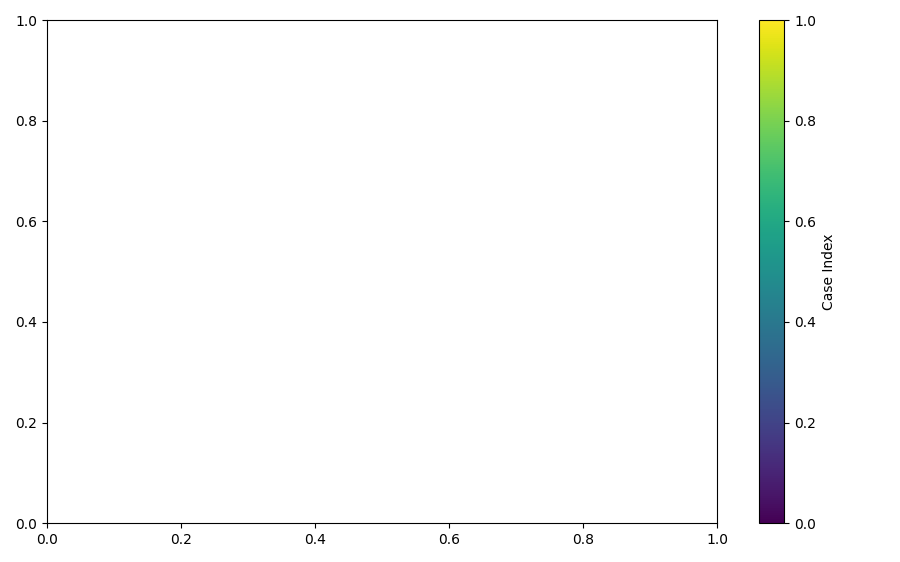

In [21]:
om.CaseViewer('driver_cases.db');

### 7\. Ensure your solver tolerances are smaller than your optimization tolerances

Otherwise you're asking your optimizer to hit something that's more precise than the function it's using. This is more solution than diagnosis.

To elaborate, if you have a solver in your model that converges your system to a tolerance of 1.e-4 and you're asking your optimizer to hit a tolerance of 1.e-6, it will never succeed. This is because the solver could terminate when the solution is "off" by 1.e-4. This noise in the design space would be bigger than the optimizer tolerance, so the optimizer would struggle and fail. Sometimes it might not fail but might converge poorly or converge to a non-optimal solution.

There are some mathematical understandings of different optimizers which generally err on the side of converging yourself much more than the optimization tolerance. However, it generally is okay to have your optimizer tolerance be about two orders of magnitude looser than your solver tolerance, e.g. `opt_tol = 1.e-6` and `solver_tol = 1.e-8`.

Here are two example cases that show how solver tolerance affects optimization convergence.

In the first, our solver tolerance is 1.e-2 whereas our optimization tolerance is 1.e-6. Although the solver "converges" in relatively few iterations each time, the optimizer uses 23 function evaluations.

In [22]:
from openmdao.test_suite.components.sellar_feature import SellarMDA

import numpy as np

# define Sellar MDA problem
prob = om.Problem(model=SellarMDA())

model = prob.model
model.add_design_var('z', lower=np.array([-10.0, 0.0]),
                          upper=np.array([10.0, 10.0]))
model.add_design_var('x', lower=0.0, upper=10.0)
model.add_objective('obj')
model.add_constraint('con1', upper=0.0)
model.add_constraint('con2', upper=0.0)

# set driver and show driver options
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['tol'] = 1.e-6

prob.setup()
model.cycle.nonlinear_solver.options['atol'] = 1.e-2
results = prob.run_driver()


=====
cycle
=====
NL: NLBGS Converged in 4 iterations

=====
cycle
=====
NL: NLBGS Converged in 1 iterations

=====
cycle
=====
NL: NLBGS Converged in 3 iterations

=====
cycle
=====
NL: NLBGS Converged in 3 iterations

=====
cycle
=====
NL: NLBGS Converged in 3 iterations

=====
cycle
=====
NL: NLBGS Converged in 3 iterations

=====
cycle
=====
NL: NLBGS Converged in 2 iterations

=====
cycle
=====
NL: NLBGS Converged in 2 iterations

=====
cycle
=====
NL: NLBGS Converged in 1 iterations

=====
cycle
=====
NL: NLBGS Converged in 1 iterations

=====
cycle
=====
NL: NLBGS Converged in 1 iterations

=====
cycle
=====
NL: NLBGS Converged in 1 iterations

=====
cycle
=====
NL: NLBGS Converged in 1 iterations

=====
cycle
=====
NL: NLBGS Converged in 3 iterations

=====
cycle
=====
NL: NLBGS Converged in 3 iterations

=====
cycle
=====
NL: NLBGS Converged in 3 iterations

=====
cycle
=====
NL: NLBGS Converged in 2 iterations

=====
cycle
=====
NL: NLBGS Converged in 2 iterations

=====
cyc

More concernginly, though, the resulting optimum is wildly wrong. The variable values are nowhere close to the actual optimum, but the optimizer doesn't know this because the solver never sufficiently converged the system.

In [23]:
prob.model.list_outputs(units=True)

5 Explicit Output(s) in 'model'

varname   val             units
--------  --------------  -----
cycle
  d1
    y1    [25.58831389]   None 
  d2
    y2    [12.0584914]    None 
obj_cmp
  obj     [28.5883189]    None 
con_cmp1
  con1    [-22.42831389]  None 
con_cmp2
  con2    [-11.9415086]   None 


0 Implicit Output(s) in 'model'




[('cycle.d1.y1', {'val': array([25.58831389]), 'units': None}),
 ('cycle.d2.y2', {'val': array([12.0584914]), 'units': None}),
 ('obj_cmp.obj', {'val': array([28.5883189]), 'units': None}),
 ('con_cmp1.con1', {'val': array([-22.42831389]), 'units': None}),
 ('con_cmp2.con2', {'val': array([-11.9415086]), 'units': None})]

In this next case we have the exact same system but we converge the inner cycle to 1.e-8 while keeping the optimizer tolerance at 1.e-6. This makes the optimizer converge fantastically with just 10 function evaluations.

In [24]:
# define Sellar MDA problem
prob = om.Problem(model=SellarMDA())

model = prob.model
model.add_design_var('z', lower=np.array([-10.0, 0.0]),
                          upper=np.array([10.0, 10.0]))
model.add_design_var('x', lower=0.0, upper=10.0)
model.add_objective('obj')
model.add_constraint('con1', upper=0.0)
model.add_constraint('con2', upper=0.0)

# set driver and show driver options
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['tol'] = 1.e-6

prob.setup()
model.cycle.nonlinear_solver.options['atol'] = 1.e-8
prob.run_driver()


=====
cycle
=====
NL: NLBGS Converged in 7 iterations

=====
cycle
=====
NL: NLBGS Converged in 1 iterations

=====
cycle
=====
NL: NLBGS Converged in 8 iterations

=====
cycle
=====
NL: NLBGS Converged in 8 iterations

=====
cycle
=====
NL: NLBGS Converged in 8 iterations

=====
cycle
=====
NL: NLBGS Converged in 7 iterations

=====
cycle
=====
NL: NLBGS Converged in 7 iterations

=====
cycle
=====
NL: NLBGS Converged in 6 iterations

=====
cycle
=====
NL: NLBGS Converged in 5 iterations

=====
cycle
=====
NL: NLBGS Converged in 4 iterations

=====
cycle
=====
NL: NLBGS Converged in 4 iterations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.183394110176784
            Iterations: 9
            Function evaluations: 10
            Gradient evaluations: 9
Optimization Complete
-----------------------------------


False

Even better, the resulting outputs are at the correct optimal design. This simple example shows the importance of selecting reasonable tolerance values for solvers and optimizers.

In [25]:
prob.model.list_outputs()

5 Explicit Output(s) in 'model'

varname   val              
--------  -----------------
cycle
  d1
    y1    [3.16000016]     
  d2
    y2    [3.75527786]     
obj_cmp
  obj     [3.18339411]     
con_cmp1
  con1    [-1.60650155e-07]
con_cmp2
  con2    [-20.24472214]   


0 Implicit Output(s) in 'model'




[('cycle.d1.y1', {'val': array([3.16000016])}),
 ('cycle.d2.y2', {'val': array([3.75527786])}),
 ('obj_cmp.obj', {'val': array([3.18339411])}),
 ('con_cmp1.con1', {'val': array([-1.60650155e-07])}),
 ('con_cmp2.con2', {'val': array([-20.24472214])})]

### 8\. Scale your problem

Sometimes this is more of an art than a science, but luckily we have some rules of thumb and tools to help. The motivation behind scaling is that the optimizer should see all of the design variable and Jacobian values as roughly the same order of magnitude.

There are many examples of physical systems where without scaling it would result in a poorly posed optimization problem. One example is in aircraft wing design. If you have design variables for the thickness of your wing skin in meters (on the order 1.e-3) and your engine thrust in Newtons (on the order 1.e6) the optimizer would understandably prioritize these variables differently. We can and should scale these values to produce a better-posed optimization problem.

A good rule of thumb is scale the design variables so the lower and upper bounds correspond to 0 and 1 respectively. Then, you can use ref and ref0 values to scale the Jacobian to not be too badly skewed, though this is highly problem dependent. [OpenMDAO already has great docs](https://openmdao.org/twodocs/versions/latest/features/core_features/working_with_components/scaling.html) on this so I won't reinvent the wheel here; please read through that page instead.

Another helpful tool built into OpenMDAO is the [scaling report](https://openmdao.org/twodocs/versions/latest/features/model_visualization/view_scaling_report.html) whose use is [detailed here](https://openmdao.org/twodocs/versions/latest/other_useful_docs/om_command.html#om-command-scaling). This has both a tabular and a visual output of your scaled variable and Jacobian values. This is *extremely* helpful at quickly identifying problematic scalings between design variables and functions of interest.

Here is a screenshot from this scaling report tool. The blocks are colored based on values in the Jacobian. In broad terms, you want these values to be roughly the same order of magnitude. You can imagine that the 

![View optimization variables and iterations](scaling_report_jac.png)


### 9\. Manually investigate and visualize the design space

This is related to understanding your model inside and out, but now we need to think about how an optimizer would operate within this space. Your optimizer might converge poorly or seem to do well at first and make poor progress. There are a few specific types of design spaces to look for.

You might be dealing with a very flat design space. What I mean by this is that near the optimum the derivatives do not have a large magnitude or slope. There are many physical examples of this in multidisciplinary systems. The cost of energy (COE) for wind turbines and a lot of performance metrics in trajectory optimizations are two examples.

Another potential issue in your design space could be a saddle point. This is where the derivatives in one direction are positive and negative in another direction, but are 0 at the saddle point. These are quite challenging for an optimizer to handle as they may be drawn to that point as it has derivative values of 0, but then the function can be improved by moving off of that point. That type of singularity generally causes issues for convergence. Here is Figure 4.3 from [Engineering Design Optimization by Martins and Ning](https://mdobook.github.io/) which shows a potentially troublesome function featuring two saddle points.

![Saddle points and extrema from Engineering Design Optimization](saddle_points.png)

If your optimizer is converging to different optima, you might have a multimodal design space. This means that there are multiple different minima in the design space. Visualizing your design space will allow you to see this, though that is challenging to do for highly dimensional problems. That being said, you can always view a subset of the problems' dimensions by focusing on just a few variables at a time. Wind turbine layout optimization is a notoriously multimodal problem. This plot from [Stanley and Ning (2019)](https://wes.copernicus.org/articles/4/663/2019/wes-4-663-2019.pdf) shows the sharp multimodality of the energy production in a wind farm based on varying the location of one wind turbine in a farm of 100 turbines.

![Wind turbine layout multimodality from Stanley and Ning, 2019](multimodality.png)

### 10\. Try a different optimizer

Use the correct optimizer for your problem. If you have a nice and smooth design space, SLSQP or SNOPT might be the best. A genetic algorithm or particle swarm method might be best for discrete or multimodal problems. IPOPT does well for some trajectory problems. There are many different optimizers that handle problems differently and one may be more advantageous for your formulation.

Figures 1.15 and 1.22 from [Engineering Design Optimization by Martins and Ning](https://mdobook.github.io/) go through all the permutations and types of optimization problem formulations and optimization algorithms respectively. This is a great treatment of the available types of optimizers. Make sure you're using an appropriate optimizer for your problem type.

![Optimization problem formulation classification](opt_problems.png)

![Optimization algorithm classification](opt_algos.png)

